In [1]:
import os

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import ConnectionPatch
from IPython.display import HTML

import tools.dataset_tools as dataset_tools
from tools.frame_pb2 import Frame
import tools.plot_tools as plot_tools
import numpy as np
from track import Track
from camera import Camera
from Association import Association
import uuid
import matplotlib.patches
import matplotlib.collections
matplotlib.rcParams['animation.embed_limit'] = 512

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
class SensorData():
    def __init__(self, kind: str, data, timestamp: float, frame_id: int, H: np.ndarray = None, R: np.ndarray = None, **kwargs):
        self.frame_id = frame_id
        self.kind = kind
        self.data = data
        self.timestamp = timestamp
        self.assigned = False
        self.H = H
        self.R = R
        # generate uuid
        self.id = uuid.uuid4()
        self.misc = {
            **kwargs
        }
        

In [3]:
def H_jac(p_x, p_y, p_z, T, K):
    """Calculate the Jacobian of the measurement function h(x)"""
    r_11 = T[0, 0]
    r_12 = T[0, 1]
    r_13 = T[0, 2]
    r_21 = T[1, 0]
    r_22 = T[1, 1]
    r_23 = T[1, 2]
    r_31 = T[2, 0]
    r_32 = T[2, 1]
    r_33 = T[2, 2]
    t_1 = T[0, 3]
    t_2 = T[1, 3]
    t_3 = T[2, 3]

    f_x = K[0,0] # also f_i in the lecture
    f_y = K[1,1] # also f_j in the lecture

    H = np.zeros((2, 6))
    H[0, 0] = f_x * (
        r_11*(p_x*r_21 + p_y * r_22 + p_z * r_23 + t_2) /
        (p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1)**2
        - r_21/(p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1))

    H[0, 1] = f_x * (
        r_12*(p_x*r_21 + p_y * r_22 + p_z * r_23 + t_2) /
        (p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1)**2
        - r_22/(p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1))

    H[0, 2] = f_x * (
        r_13*(p_x*r_21 + p_y * r_22 + p_z * r_23 + t_2) /
        (p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1)**2
        - r_23/(p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1))
    
    H[1, 0] = f_y * (
        r_11*(p_x*r_31 + p_y * r_32 + p_z * r_33 + t_3) /
        (p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1)**2
        - r_31/(p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1))
    
    H[1, 1] = f_y * (
        r_12*(p_x*r_31 + p_y * r_32 + p_z * r_33 + t_3) /
        (p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1)**2
        - r_32/(p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1))
    
    H[1, 2] = f_y * (
        r_13*(p_x*r_31 + p_y * r_32 + p_z * r_33 + t_3) /
        (p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1)**2
        - r_33/(p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1))
    
    H = np.zeros((2, 6))
    H[0, 0] = f_x * (p_y/p_x**2)
    H[0, 1] = - f_x * (1/p_x)
    H[1, 0] = f_y * (p_z/p_x**2)
    H[1, 2] = - f_y * (1/p_x)
    
    return H

def h(p_x, p_y, p_z, T, K):
    """Measurement function h(x)"""
    r_11 = T[0, 0]
    r_12 = T[0, 1]
    r_13 = T[0, 2]
    r_21 = T[1, 0]
    r_22 = T[1, 1]
    r_23 = T[1, 2]
    r_31 = T[2, 0]
    r_32 = T[2, 1]
    r_33 = T[2, 2]
    t_1 = T[0, 3]
    t_2 = T[1, 3]
    t_3 = T[2, 3]

    f_x = K[0,0] # also f_i in the lecture
    f_y = K[1,1] # also f_j in the lecture

    c_i = K[0,2]
    c_j = K[1,2]

    z = np.zeros((2, 1))
    z[0] = c_i - f_x * (
        p_x*r_21 + p_y * r_22 + p_z * r_23 + t_2) / (
        p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1)
    z[1] = c_j - f_y * (
        p_x*r_31 + p_y * r_32 + p_z * r_33 + t_3) / (
        p_x * r_11 + p_y * r_12 + p_z * r_13 + t_1)
    
    z = np.zeros((2, 1))
    z[0] = c_i - f_x * (
        p_y) / (p_x)
    z[1] = c_j - f_y * (
        p_z) / (p_x)
    return z

In [4]:
all_detections = []
num_detections = []
for i in range(199):
    frame = dataset_tools.read_frame(f"/app/data_2/frame_{i}.pb")
    num_detections.append(
        {"cam": len(frame.cameras[0].detections),
         "lidar": len(frame.lidars[0].detections)}
    )
    for detection in frame.cameras[0].detections:
        all_detections.append(
            SensorData("cam",
                       data=detection,
                       timestamp=frame.cameras[0].timestamp,
                       frame_id=i,
                       H=h,
                       K=frame.cameras[0].K,
                       T=frame.cameras[0].T,
                       H_j = H_jac
                       )
        )
    for detection in frame.lidars[0].detections:
        all_detections.append(
            SensorData("lidar",
                       data=detection,
                       timestamp=frame.lidars[0].timestamp,
                       frame_id=i,
                       H=np.array([[1, 0, 0, 0, 0, 0],
                                   [0, 1, 0, 0, 0, 0],
                                   [0, 0, 1, 0, 0, 0]]),
                       R=np.array([[0.1, 0, 0],
                                   [0, 0.1, 0],
                                   [0, 0, 0.1]])
                       )

        )

# sort detections by timestamp
all_detections.sort(key=lambda x: x.timestamp)


In [5]:
K = np.array(frame.cameras[0].K).reshape(3,3)
display(K)
# focal lenghts in pixels
f_x = K[0,0] # also f_i in the lecture
f_y = K[1,1] # also f_j in the lecture
# calculate principal point in image coordinates
principal_point = K[0:2,2]
print(principal_point)

array([[2.08309131e+03, 0.00000000e+00, 9.57293823e+02],
       [0.00000000e+00, 2.08309131e+03, 6.50569763e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

[957.29382324 650.56976318]


In [6]:
T = np.array(frame.cameras[0].T).reshape(4,4)
display(T)

array([[ 0.00828053, -0.99991506,  0.01006629, -0.05696378],
       [ 0.01005313, -0.00998289, -0.99989963,  2.09998655],
       [ 0.99991518,  0.0083809 ,  0.00996961, -1.56518698],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

# KF with the Lidar detections

In [7]:
frames = [dataset_tools.read_frame(f"/app/data_2/frame_{i}.pb") for i in range(0, 199)]


In [9]:
# looping over all frames
frames = [dataset_tools.read_frame(
    f"/app/data_2/frame_{i}.pb") for i in range(0, 199)]
tracks = []

# creating a camera object, to determine if points are within the FOV
camera = Camera(np.array(frames[0].cameras[0].T).reshape((4,4)))

last_timestamp = -1
for frame_id, frame in enumerate(frames):
    lidar_measurements = [det for det in all_detections if det.frame_id == frame_id and det.kind == "lidar"]
    camera_measurements = [det for det in all_detections if det.frame_id == frame_id and det.kind == "cam"]


    active_tracks = [track for track in tracks if track.range[1] == -1]
    # predict all tracks
    for track in active_tracks:
        track.predict(dt=float(frame.lidars[0].timestamp) - last_timestamp, frame_id = frame_id)
        track.assigned = False

    if len(lidar_measurements) != 0 and len(active_tracks) != 0:
        # associate measurements to tracks
        assoc_matrix = Association().associate(active_tracks, lidar_measurements)
        association = {}
        for id, track in enumerate(active_tracks):
            for idx in np.argsort(assoc_matrix[id, :]):
                if assoc_matrix[id, idx] == np.inf:
                    #print("no association found")
                    break
                if lidar_measurements[idx].id not in association.values():
                    #print("association found")
                    association[track.id] = lidar_measurements[idx].id
                    lidar_measurements[idx].assigned = True
                    track.score = track.score * 0.9 + 0.1
                    track.assigned = True
                    break
    
    # filter for tracks which are in FOV
    tracks_in_fov = [track for track in active_tracks if track.in_fov]
    # associate image detections to tracks
    if len(camera_measurements) != 0 and len(tracks_in_fov) != 0:
        assoc_matrix_cam = Association().associate(tracks_in_fov, camera_measurements)
        for id, track in enumerate(tracks_in_fov):
            for idx in np.argsort(assoc_matrix_cam[id, :]):
                if assoc_matrix_cam[id, idx] == np.inf:
                    #print("no association found")
                    break
                if camera_measurements[idx].id not in association.values():
                    #print("association found")
                    association[track.id] = camera_measurements[idx].id
                    camera_measurements[idx].assigned = True
                    track.score = track.score * 0.9 + 0.1
                    track.assigned = True
                    break

    unassigned_measurements = [m for m in lidar_measurements if (
        (not m.assigned) and m.kind == "lidar" and not m.assigned)]

    # update all tracks
    for track in active_tracks:
        if track.assigned:
            paired_measurement = None
            for m in lidar_measurements:
                if m.id == association[track.id]:
                    paired_measurement = m
                    break
            track.update(np.array(paired_measurement.data.pos), paired_measurement.R, paired_measurement.H)
        else:
            track.score = max(0, track.score - 0.1)
            if track.score < 0.3:
                track.range[1] = frame_id

    for m in unassigned_measurements:
        # create new track
        pos = np.pad(np.array(m.data.pos), (0, 3), 'constant', constant_values=(0))
        tracks.append(
            Track(init_state=pos, frame_id = frame_id, camera=camera)
        )
    
    last_timestamp = float(frame.lidars[0].timestamp)

# terminate all tracks
for track in tracks:
    if track.range[1] == -1:
        track.range[1] = len(frames) - 1

fig, ax = plt.subplots(2,1)
fig.set_size_inches(10, 10)

img = ax[0].imshow(dataset_tools.decode_img(frames[0].cameras[0]))

ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('y [m]')
ax[1].set_ylim([-60, 120])
ax[1].set_xlim([-30, 30])
#ax[1].set_aspect('equal')

points_img = ax[0].plot([], [], 'o', label="projected points from the kalman filter")
points = ax[1].plot([], [], 'o')
rects = matplotlib.collections.PatchCollection([], facecolor='none', linewidth=1)
points_cam = ax[0].plot([], [], 'o', label="ground truth from camera")
# plot rectangles
ax[1].add_collection(rects)
ax[0].legend()

# draw lines 45 degrees from the origin
# camera offset from T matrix
camera_offset = np.array(frames[0].cameras[0].T).reshape((4,4))[:3, 3]
print(camera_offset)
ax[1].plot([-camera_offset[0], 30-camera_offset[0]], [0-camera_offset[1], 30-camera_offset[1]], color='black', linestyle='--')
ax[1].plot([-30-camera_offset[0], -camera_offset[0]], [30-camera_offset[1], 0-camera_offset[1]], color='black', linestyle='--')

last_connection = None
def animate(idx):
    img.set_data(dataset_tools.decode_img(frames[idx].cameras[0]))

    data = np.array([det.pos for det in frames[idx].lidars[0].detections])
    y, x = data[:, 0], data[:, 1]
    points[0].set_data(-(x), y)

    # plot points on image for tracks in FOV
    
    x_img, y_img = [], []
    for track in tracks:
        if track.range[0] <= idx and track.range[1] >= idx:
            if track.record[idx]["in_fov"]:
                p_x, p_y, p_z = track.record[idx]["state"][:3]
                x,y = h(p_x, p_y, p_z-2.5,
                        np.array(frames[0].cameras[0].T).reshape((4,4)),
                        np.array(frames[0].cameras[0].K).reshape((3,3))
                        )
                x_img.append(x)
                y_img.append(y)
    
    points_img[0].set_data(x_img, y_img)

    rect_pos  = [track.record[idx]["state"][:2] for track in tracks if track.range[0] <= idx and track.range[1] >= idx]
    rect_in_fov = [[0,1,0] if track.record[idx]["in_fov"] else [1,0,0] for track in tracks if track.range[0] <= idx and track.range[1] >= idx]
    # draw rectangles, paint blue if in FOV, red if not
    rects.set_paths([matplotlib.patches.Rectangle((-(y + 5), (x - 5)), 10, 10, edgecolor=[0,1,0]) for (x, y), c in zip(rect_pos, rect_in_fov)])
    rects.set_edgecolors(rect_in_fov)

    # draw camera detection points
    points_pos_cam  = np.array(
        [np.array(det.data.bbox)[:2] for det in all_detections if det.frame_id == idx and det.kind == "cam"])
    print(points_pos_cam.shape)
    points_cam[0].set_data(points_pos_cam[:, 0], points_pos_cam[:, 1])

    return (points[0],points_cam[0], rects, points_img[0])


# Create the animation
anim = animation.FuncAnimation(
    fig, animate, frames=5, interval=50, blit=True)

# Display the animation
# Convert the animation to HTML5 video
html_video = HTML(anim.to_jshtml())

# Display the video in Jupyter
display(html_video)


AttributeError: bbox

image shape: (1280, 1920, 3)
957.2938232421875 650.5697631835938
[748.98469238] [442.26063232]


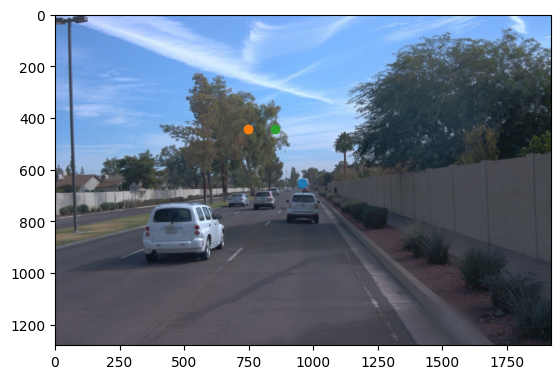

In [ ]:
print(f"image shape: {dataset_tools.decode_img(frames[0].cameras[0]).shape}")
K = np.array(frames[0].cameras[0].K).reshape((3,3))
c_i = K[0,2]
c_j = K[1,2]

z = 2
front = 20
lr = 2
x,y = h(front, lr, z,
  np.array(frames[0].cameras[0].T).reshape((4, 4)),
  K
  )
plt.imshow(dataset_tools.decode_img(frames[0].cameras[0]))

plt.plot(c_i, c_j, 'o')
plt.plot(x, y, 'o')
print(c_i,c_j)
print(x,y)
z = 4
front = 40
lr = 2
x,y = h(front, lr, z,
  np.array(frames[0].cameras[0].T).reshape((4, 4)),
  K
  )
plt.plot(x, y, 'o')


In [ ]:
np.array(frames[0].cameras[0].K).reshape((3, 3))

array([[2.08309131e+03, 0.00000000e+00, 9.57293823e+02],
       [0.00000000e+00, 2.08309131e+03, 6.50569763e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

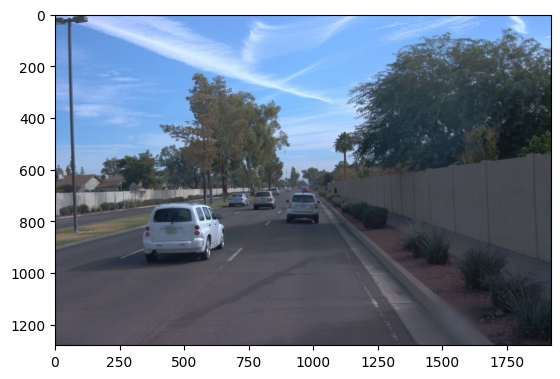

In [ ]:
plt.imshow(dataset_tools.decode_img(frames[0].cameras[0]))